In [63]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import xarray as xr

In [64]:
input_data_60S_so = xr.open_dataset(f"processed_data/input_data_60S_so.nc")
MOC_60S_so = xr.open_dataset(f"processed_data/MOC_60S_so.nc")

In [65]:
input_data_60S_so.pbot_t

<xarray.DataArray 'pbot_t' (time: 349, xt_ocean: 3600)>
[1256400 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    yt_ocean  float64 ...
  * time      (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-16T12:00:00
    yu_ocean  float64 ...
    st_ocean  float64 ...
Attributes: (12/13)
    long_name:      bottom pressure on T cells [Boussinesq (volume conserving...
    units:          dbar
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_pressure_at_sea_floor
    ...             ...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...
    coordinates:    geolon_t geolat_t

In [66]:
MOC_60S_so.MOC

<xarray.DataArray 'MOC' (time: 349)>
[349 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-16T12:00:00
    yu_ocean  float64 ...
    st_ocean  float64 ...
    sigma_2   float64 ...

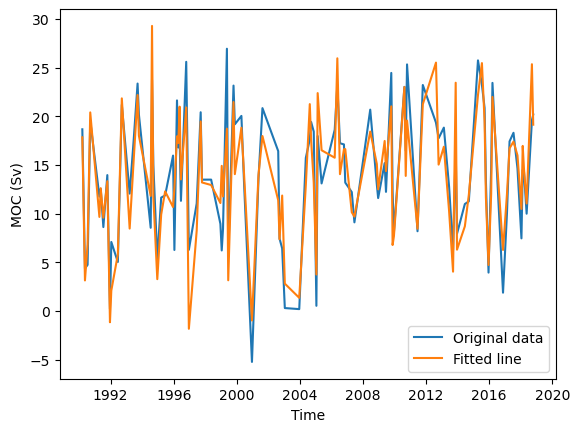

[[1.         0.88468543]
 [0.88468543 1.        ]]


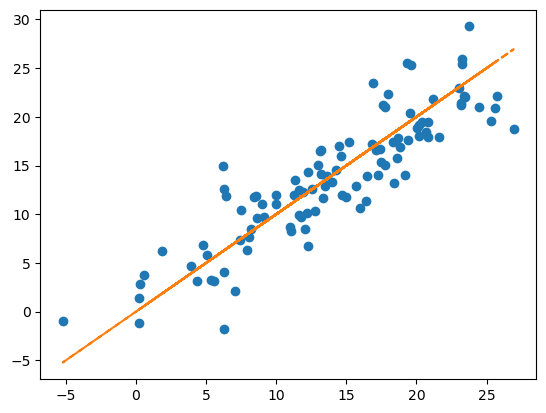

In [71]:
from sklearn import linear_model
from sklearn import model_selection

linreg = linear_model.LinearRegression()

x = input_data_60S_so.pbot_t
y = MOC_60S_so.MOC

out = model_selection.train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_test, y_train, y_test = out

linreg.fit(x_train, y_train)

x_test = x_test.sortby('time')
y_test = y_test.sortby('time')

plt.plot(x_test.time, y_test*1e-6, label='Original data', markersize=5)
plt.plot(x_test.time, linreg.predict(x_test)*1e-6, label='Fitted line')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MOC (Sv)')
plt.show()

print(np.corrcoef(linreg.predict(x_test), y_test))

plt.plot(y_test*1e-6, linreg.predict(x_test)*1e-6, 'o')
plt.plot(y_test*1e-6, y_test*1e-6, '--')

(105, 3600)
[[nan nan]
 [nan  1.]]


/Users/tomcowperthwaite/opt/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tomcowperthwaite/opt/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[[1.         0.80769715]
 [0.80769715 1.        ]]
[[1.        0.3597157]
 [0.3597157 1.       ]]


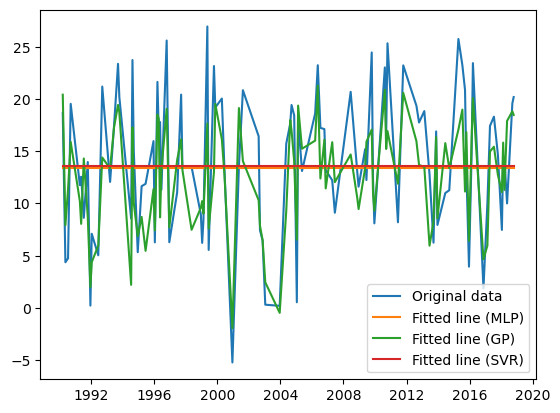

In [68]:
from sklearn.neural_network import MLPRegressor

print(x_test.to_numpy().shape)

MLP_1 = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(1), random_state=1, learning_rate='adaptive', )
MLP_1 = MLP_1.fit(x_train.to_numpy(), y_train.to_numpy())
print(np.corrcoef(MLP_1.predict(x_test.to_numpy()), y_test.to_numpy()))

plt.plot(x_test.time, y_test*1e-6, label='Original data', markersize=5)
plt.plot(x_test.time, MLP_1.predict(x_test.to_numpy())*1e-6, label='Fitted line (MLP)')



from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor()
gp.fit(x_train.to_numpy(), y_train.to_numpy())
print(np.corrcoef(gp.predict(x_test.to_numpy()), y_test.to_numpy()))

plt.plot(x_test.time, gp.predict(x_test.to_numpy())*1e-6, label='Fitted line (GP)')



from sklearn.svm import SVR
SVR = SVR()
SVR.fit(x_train.to_numpy(), y_train.to_numpy())
print(np.corrcoef(SVR.predict(x_test.to_numpy()), y_test.to_numpy()))

plt.plot(x_test.time, SVR.predict(x_test.to_numpy())*1e-6, label='Fitted line (SVR)')
plt.legend()
